In [ ]:
!pip install -q lightgbm xgboost imbalanced-learn

# === 2. IMPORT LIBRARIES ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import xgboost as xgb
from collections import Counter

In [ ]:

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [ ]:

df = pd.read_csv('/content/winequality.csv')
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [ ]:
# Fill missing values and encode 'type' column
for col in df.columns:
    if df[col].dtype != 'object':
        df[col] = df[col].fillna(df[col].mean())

df['type'] = pd.get_dummies(df['type'], drop_first=True)  # Red = 0, White = 1


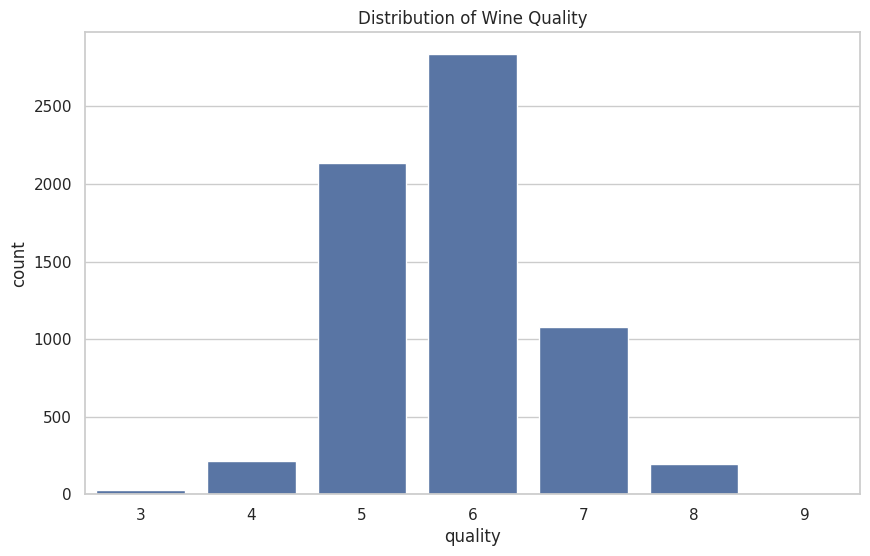

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='quality', data=df)
plt.title("Distribution of Wine Quality")
plt.show()


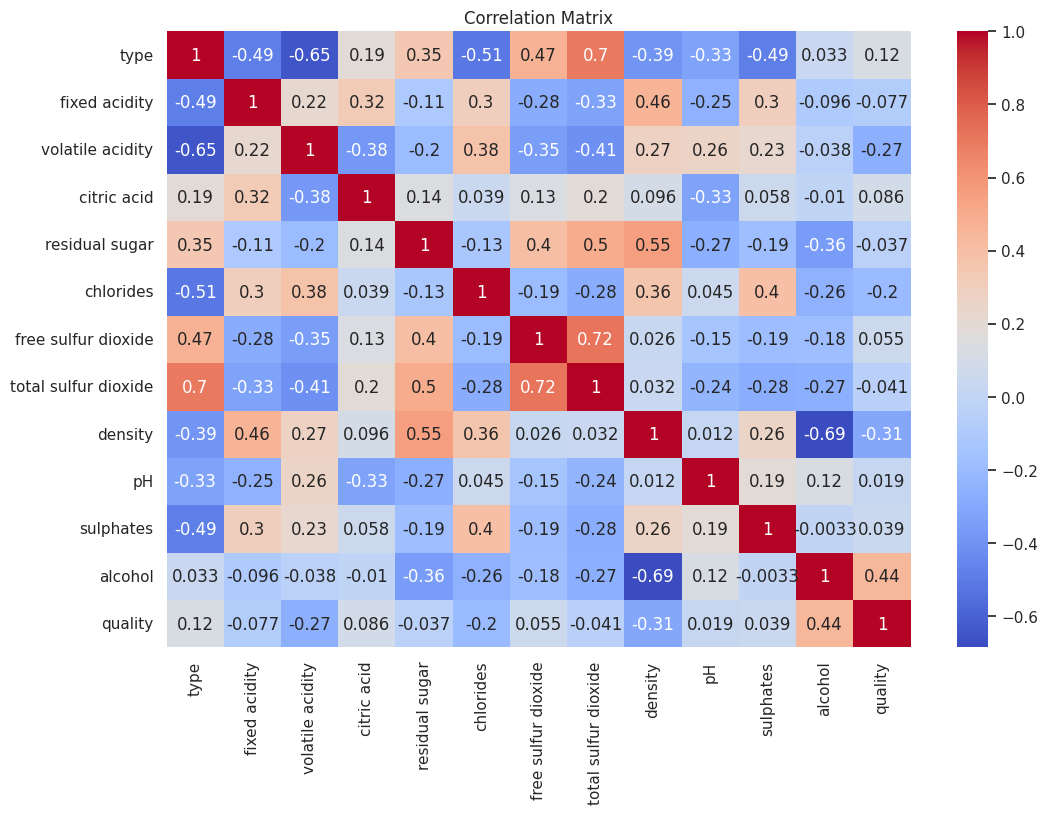

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [ ]:
# === 6. FEATURE/ TARGET SPLIT + SMOTE ===
X = df.drop(columns=['quality'])
y = df['quality']

In [ ]:
print("Before SMOTE:", y.value_counts())
smote = SMOTE(k_neighbors=4)
X_res, y_res = smote.fit_resample(X, y)
print("After SMOTE:", y_res.value_counts())

Before SMOTE: quality
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: count, dtype: int64
After SMOTE: quality
6    2836
5    2836
7    2836
8    2836
4    2836
3    2836
9    2836
Name: count, dtype: int64


In [ ]:
def evaluate_model(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # ----> Check and adjust class labels if necessary <----
    if isinstance(model, xgb.XGBClassifier):
        # Get unique class labels
        unique_labels = np.unique(y)

        # Create mapping to expected range (0-6)
        label_mapping = {label: i for i, label in enumerate(unique_labels)}

        # Apply mapping to target variables
        y_train = y_train.map(label_mapping)
        y_test = y_test.map(label_mapping)

    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test) * 100

    # If XGBClassifier, use mapped labels for cross-validation
    if isinstance(model, xgb.XGBClassifier):
        cv_score = np.mean(cross_val_score(model, X, y.map(label_mapping), cv=5)) * 100
    else:
        cv_score = np.mean(cross_val_score(model, X, y, cv=5)) * 100


    print(f"\nModel: {model.__class__.__name__}")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Cross-Validation Score: {cv_score:.2f}%")

    y_pred = model.predict(X_test)
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [ ]:
# === 8. MODEL TRAINING ===
models = [
    LogisticRegression(max_iter=1000),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    ExtraTreesClassifier(),
    xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    lgb.LGBMClassifier() ]

In [ ]:

for model in models:
    evaluate_model(model, X_res, y_res)


Model: LogisticRegression
Accuracy: 44.57%
Cross-Validation Score: 41.87%

Confusion Matrix:
 [[398 150  70  44   0  16  46]
 [129 379  91  26  12  12  49]
 [117 151 238 118  24  23  36]
 [ 52  74 173 130 100  85 112]
 [ 13  33  76  74 167 183 160]
 [  5  13  72  50 116 319 161]
 [ 43   0   0   0  42   0 581]]

Classification Report:
               precision    recall  f1-score   support

           3       0.53      0.55      0.54       724
           4       0.47      0.54      0.51       698
           5       0.33      0.34      0.33       707
           6       0.29      0.18      0.22       726
           7       0.36      0.24      0.29       706
           8       0.50      0.43      0.46       736
           9       0.51      0.87      0.64       666

    accuracy                           0.45      4963
   macro avg       0.43      0.45      0.43      4963
weighted avg       0.43      0.45      0.43      4963


Model: DecisionTreeClassifier
Accuracy: 79.79%
Cross-Validation 

In [ ]:
ensemble = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier()),
    ('et', ExtraTreesClassifier()),
    ('lgbm', lgb.LGBMClassifier())
], voting='soft')

In [ ]:
evaluate_model(ensemble, X_res, y_res)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2807
[LightGBM] [Info] Number of data points in the train set: 14889, number of used features: 12
[LightGBM] [Info] Start training from score -1.952987
[LightGBM] [Info] Start training from score -1.940752
[LightGBM] [Info] Start training from score -1.944970
[LightGBM] [Info] Start training from score -1.953935
[LightGBM] [Info] Start training from score -1.944501
[LightGBM] [Info] Start training from score -1.958685
[LightGBM] [Info] Start training from score -1.925896
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] 

In [ ]:
# === 10. USER INPUT PREDICTION WITH COLUMN MATCHING ===

# Get column names used in training
expected_columns = list(X_res.columns)

# Define valid ranges for each feature (match with expected columns)
feature_ranges = {
    'type': (0, 1),  # 0 = Red, 1 = White
    'fixed acidity': (2.0, 16.0),
    'volatile acidity': (0.1, 1.5),
    'citric acid': (0.0, 1.0),
    'residual sugar': (0.6, 15.0),
    'chlorides': (0.01, 0.3),
    'free sulfur dioxide': (1.0, 70.0),
    'total sulfur dioxide': (6.0, 300.0),
    'density': (0.9900, 1.0050),
    'pH': (2.8, 4.2),
    'sulphates': (0.2, 2.0),
    'alcohol': (8.0, 15.0),

}

print("\n🔍 Enter wine features (values must be within valid ranges):")

user_input = []
for col in expected_columns:
    # Get range for the current feature
    min_val, max_val = feature_ranges[col]
    while True:
        try:
            val = float(input(f"{col} [{min_val} - {max_val}]: "))
            if min_val <= val <= max_val:
                user_input.append(val)
                break
            else:
                print(f"⚠️ Value out of range! Enter between {min_val} and {max_val}")
        except ValueError:
            print("⚠️ Invalid input! Enter a number.")

# Create DataFrame with correct column order
user_df = pd.DataFrame([user_input], columns=expected_columns)

# Predict quality
predicted_quality = ensemble.predict(user_df)[0]
print(f"\n✅ Predicted Wine Quality: {predicted_quality}")



🔍 Enter wine features (values must be within valid ranges):
type [0 - 1]: 0
fixed acidity [2.0 - 16.0]: 6
volatile acidity [0.1 - 1.5]: 1
citric acid [0.0 - 1.0]: 1
residual sugar [0.6 - 15.0]: 10
chlorides [0.01 - 0.3]: 0.3
free sulfur dioxide [1.0 - 70.0]: 69
total sulfur dioxide [6.0 - 300.0]: 269
density [0.99 - 1.005]: 1
pH [2.8 - 4.2]: 3
sulphates [0.2 - 2.0]: 2
alcohol [8.0 - 15.0]: 14

✅ Predicted Wine Quality: 7


In [ ]:
import joblib
joblib.dump(ensemble, 'ensemble_model.pkl') # Added a comma between the filename and the extension

['ensemble_model.pkl']

In [ ]:
import joblib
joblib.dump(model, 'ensemble_model.pkl', compress=6)


['ensemble_model.pkl']